In [20]:
import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import itertools

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('..')
from pydens import Solver, NumpySampler as NS, cart_prod, plot_loss, plot_sections_3d
from pydens import add_tokens
add_tokens()

In [22]:
import numpy as np

* coming up with smoothers

In [23]:
#constants
r_well = 0.05
q_val = 100

In [413]:
# cylindric approximation of delta-function
def make_cylindric_np(c_x, c_y, r):
    """ Cylindric approximation of the delta-function.
    Numpy-one, for demo purposes. Should integrate to one.
    """
    return lambda x, y: (1+np.sign(r**2-((x-c_x)**2+(y-c_y)**2))) / (2 * np.pi * r**2)

In [414]:
cylindric = make_cylindric_np(0.5, 0.5, r_well)

In [415]:
def make_demo_np(func):
    grid = np.array(list(itertools.product(np.linspace(0, 1, 500),
                                           np.linspace(0, 1, 500))))
    plt.imshow(np.array([func(*pair) for pair in grid])
               .reshape(500, 500))
    plt.colorbar()

In [416]:
def count_integral_np(func):
    grid = np.array(list(itertools.product(np.linspace(0, 1, 500),
                                           np.linspace(0, 1, 500))))
    return(np.array([func(*pair) for pair in grid]).sum() /
           (500 * 500))

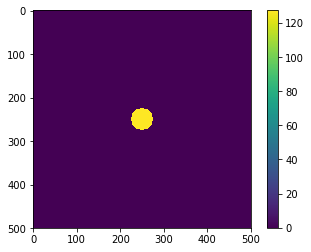

In [417]:
make_demo_np(cylindric)

In [418]:
count_integral_np(cylindric)

1.00229416961552

In [419]:
def make_cone_np(c_x, c_y, r):
    """ Cone approx of the delta-function. Numpy-one for demo.
    again, normalized to be integrated to one.
    """
    def result(x, y):
        if_inside = np.sign(r**2-((x-c_x)**2+(y-c_y)**2))
        if if_inside == -1:
            return 0
        dist = np.sqrt(((x-c_x)**2+(y-c_y)**2))
        return 3 * (1 - dist / r) / (np.pi * r**2)

    return result

In [420]:
cone_smoother = make_cone_np(0.5, 0.5, r_well)

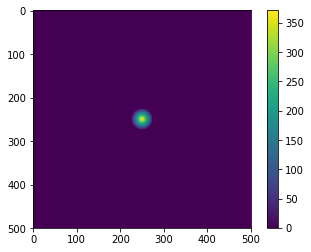

In [421]:
make_demo_np(cone_smoother)

In [422]:
count_integral_np(cone_smoother)

0.9960124823078165

* OK. this smoother is awesome. Now I have to make `tf`-version of it

In [430]:
# cone smoother
def make_cone(c_x, c_y, r):
    """ Cone smoother, tf-version.
    """
    def result(x, y):
        mul = (sign(r**2-((x-c_x)**2+(y-c_y)**2)) + 1) / 2
        dist = sqrt(((x-c_x)**2+(y-c_y)**2))
        return 3 * (1 - dist / r) * mul  / (np.pi * r**2)

    return result

In [431]:
def make_sum(f1, f2):
    return lambda *args: f1(*args) + f2(*args)

* done. Let's also make time-domain smoother

In [432]:
# fastly but smoothly goes from zero to one and stays there
t_smoother = lambda t: 2 / (1 + exp(t*(-9.0))) - 1

* running cycles using time and well-smoothers

In [433]:
def solve_and_save(bsize, s, layout, units, losses=None, combs=None, models=None, n_iters=1000):
    # set up the equation
    # k_t, k_div, q_val, r_well = 1.763512, 0.1, 0.164, 0.1
    k_t, k_div, q_val, r_well = 1.763512, 0.1, .2, 0.1

    # make sum of cone-shaped wells
    ind_well_1 = make_cone(0.8, 0.8, r_well)
    ind_well_2 = make_cone(0.2, 0.2, r_well)
    ind_well_3 = make_cone(0.8, 0.2, r_well)
    ind_well_  = make_sum(ind_well_1, ind_well_2)
    ind_well = make_sum(ind_well_, ind_well_3)

    eq = lambda p, x, y, t: k_t * D(p, t) - k_div * div(D(p), length=2) + q_val * ind_well(x, y)
    pde = {'n_dims': 3,
           'form': eq,
           'initial_condition': [300],
           'time_multiplier': 'sigmoid',
           'domain' : [[0, 1], [0, 1], [0, 5]]}

    config = {'pde': pde,
              'decay': {'name': 'invtime', 'learning_rate':0.05,
                        'decay_steps': 100, 'decay_rate': 0.01},
              'track': {
                    'rhs': lambda p, x, y, t: k_t * D(p, t) - div(k_div * D(p), length=2),
                    'loss_spatial': lambda p, x, y, t: (k_t * D(p, t) - div(k_div * D(p), length=2) +
                                                        q_val * ind_well(x, y))}
             }

    dg = Solver(config)
    full_config = dg.build_config(config, layer_size=25, path=None)
    full_config['body']['layout'] = layout
    full_config['body']['units'] = units
    full_config['head']['layout'] = ''
    full_config['head']['units'] = []

    # fit and save results
    dg = Solver(full_config)
    dg.fit(batch_size=bsize, sampler=s, n_iters=n_iters, bar='notebook')
    if losses is not None:
        losses.append(dg.loss)
    if combs is not None:
        combs.append({'batch_size': bsize,
                      'sampler': s,
                      'q': q_val,
                      'layout': layout,
                      'units': units})
    if models is not None:
        models.append(dg)
    return dg

In [434]:
s1 = ((NS('u', dim=2) & NS('e', scale=15)) |
     ((r_well / 4 * NS('n', dim=2) + (0.5, 0.5))
      & NS('e', scale=15)))

# s2 = ((NS('u', dim=2) & NS('e', scale=15)) |
#      ((r_well / 2 * NS('n', dim=2) + (0.5, 0.5))
#       & NS('u', dim=1, low=0, high=20)))
s2 = (
     (NS('u', dim=2) & NS('e', scale=5)) |
     ((r_well / 2 * NS('n', dim=2) + (0.2, 0.2))  # one multivariate gaussian for each well
      & NS('e', scale=5)) |
     ((r_well / 2 * NS('n', dim=2) + (0.8, 0.8))
       & NS('e', scale=5)) |
     ((r_well / 2 * NS('n', dim=2) + (0.8, 0.2))
       & NS('e', scale=5))
     )



s3 = ((NS('u', dim=2) & NS('e', scale=20)) |
     ((r_well * NS('n', dim=2) + (0.5, 0.5))
      & NS('u', dim=1, low=0, high=30)))

s4 = ((NS('u', dim=2) & NS('e', scale=20)) |
     ((2 * r_well * NS('n', dim=2) + (0.5, 0.5))
      & NS('u', dim=1, low=0, high=30)))

* parameters that we vary

In [435]:
# note the usage of simple architectures
import itertools

batch_sizes = [
#                 500,
#                  1500,
                2500
              ]
samplers = [
#             s1,
            s2
#             , s3
#             , s4
           ]
layoutsXunits = [
#                  {'layout': 'afaRfa+f', 'units': [35, 35, 1]},
                 {'layout': 'faRfa+f', 'units': [20, 20, 1]},
                 {'layout': 'faRfa+f', 'units': [30, 30, 1]},
                 {'layout': 'faRfa+Rfa+f', 'units': [30, 30, 30, 1]}
#                  {'layout': 'faRfa+f', 'units': [10, 10, 1]},
#                  {'layout': 'faRfa+f', 'units': [5, 5, 1]},
#                  {'layout': 'fafaf', 'units': [12, 12, 1]},
#                  {'layout': 'fafaf', 'units': [15, 15, 1]},
#                  {'layout': 'afaf', 'units': [30, 1]},
#                  {'layout': 'afaf', 'units': [40, 1]},
#                  {'layout': 'afaf', 'units': [20, 1]},
#                  {'layout': 'afaf', 'units': [10, 1]},
#                  {'layout': 'faf', 'units': [30, 1]},
#                  {'layout': 'faf', 'units': [20, 1]},
#                  {'layout': 'faf', 'units': [10, 1]},
#                  {'layout': 'af', 'units': [1]}
                ]
combinations = list(itertools.product(batch_sizes, samplers, layoutsXunits))

In [402]:
from tqdm import tqdm_notebook

In [403]:
len(combinations)

3

2500 <pydens.batchflow.sampler.Sampler object at 0x7f0c4616ee80> {'layout': 'faRfa+f', 'units': [20, 20, 1]}


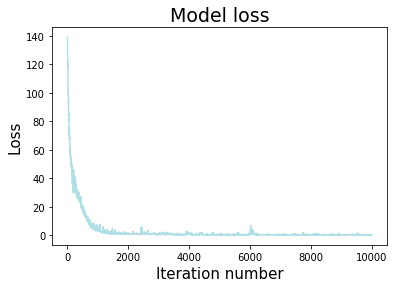

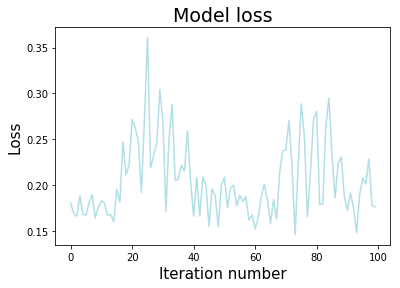

2500 <pydens.batchflow.sampler.Sampler object at 0x7f0c4616ee80> {'layout': 'faRfa+f', 'units': [30, 30, 1]}


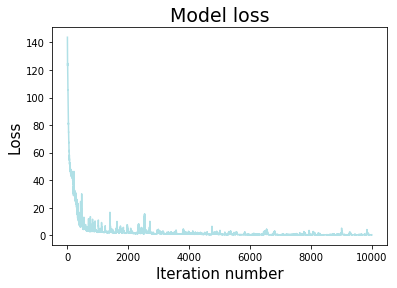

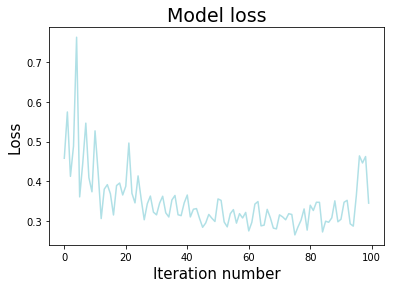

2500 <pydens.batchflow.sampler.Sampler object at 0x7f0c4616ee80> {'layout': 'faRfa+Rfa+f', 'units': [30, 30, 30, 1]}


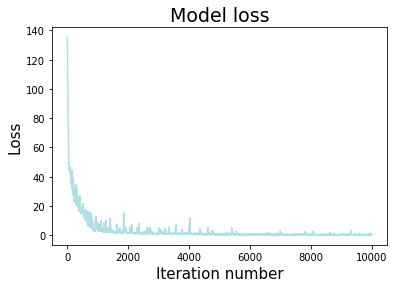

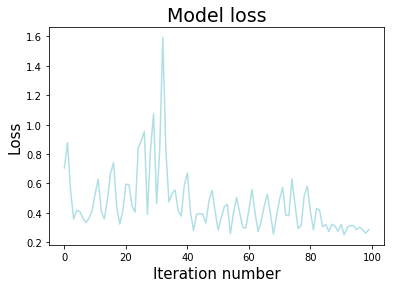

In [404]:
results = []
combs = []
models = []
for combo in tqdm_notebook(combinations[:]):
    bsize, s, layXunits = combo
    print(bsize, s, layXunits)
    layout, units = layXunits['layout'], layXunits['units']
    dg = solve_and_save(bsize, s, layout, units, results, combs, models, n_iters=10000)
    plot_loss(dg.loss[:])
    plot_loss(dg.loss[-100:])

In [436]:
len(results)

3

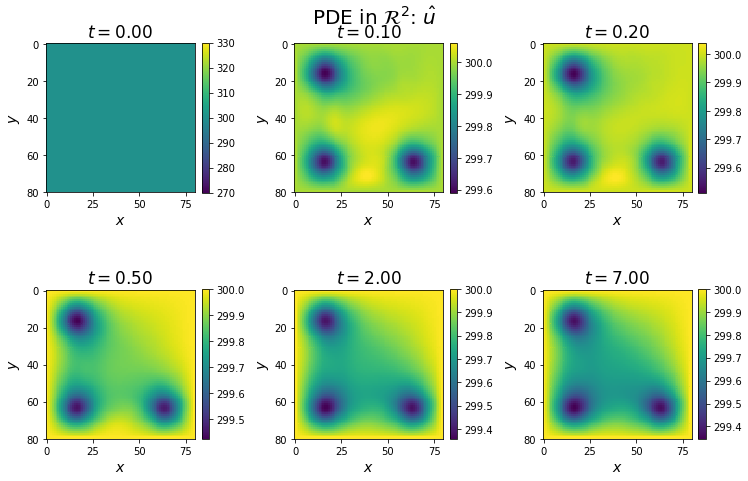

In [450]:
# check out solution-approximations
plot_sections_3d(models[-1], fetches='solution', mode='imshow',
                 timestamps=(0, 0.1 , 0.2, 0.5, 2.0, 7.0))

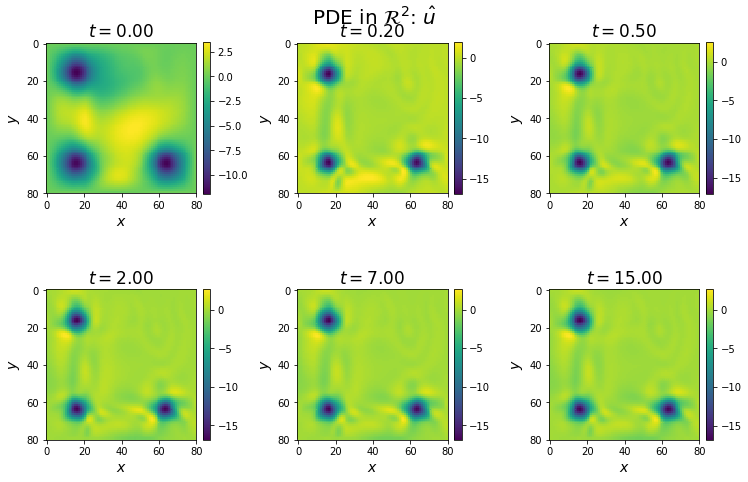

In [451]:
# and rhs-approximations
plot_sections_3d(models[-1], fetches='rhs', mode='imshow',
                 timestamps=(0, 0.2, 0.5, 2.0, 7.0, 15))

In [447]:
# and mean-value plot
def get_mean_value(model, n_points=50, n_dims=2, t=0.1):
    grid_spatial = cart_prod(*(np.linspace(0, 1, n_points), ) * n_dims)
    grid = np.concatenate([grid_spatial, np.repeat(t, grid_spatial.shape[0]).reshape(-1, 1)], axis=-1)
    tensor_values = dg.solve(grid)
    return np.mean(tensor_values)

In [448]:
ts_ = np.linspace(0, 15, 100)
vals_ = [get_mean_value(models[-1], n_dims=2, t=t) for t in ts_]

Text(0, 0.5, '$p_w(t)$')

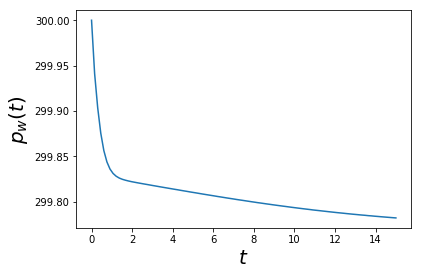

In [449]:
plt.plot(ts_, vals_)
plt.xlabel(r'$t$', fontdict={'fontsize': 20})
plt.ylabel('$p_w(t)$', fontdict={'fontsize': 20})